In [11]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec as GS
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pickle


import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp
import seaborn as sns

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
fly_id = []
for _, row in sess_df.iterrows():
    if row['rnai']==0:
        fly_id.append(row['date']+'_'+row['fly'] +'_control')
    else:
        fly_id.append(row['date']+'_'+row['fly'] +'_rnai')
sess_df['fly_id']=fly_id

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EPG_jGCaMP7f_OctB1RRNAi')
figfolder.mkdir(parents=True, exist_ok=True)


sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'session', 'closed_loop', 'rnai', 'usable',
       'fictrac_dat_file', 'notes'],
      dtype='object')


In [3]:
def load_row(row):
    if row['rnai']==0:
        outdir = pathlib.PurePath( basedir / 'control' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')    
    elif row['rnai']==1:
        outdir = pathlib.PurePath( basedir / 'rnai' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [4]:
fly_ids = sess_df['fly_id'].unique()
ctrl_fly_ids = [f for f in fly_ids if "control" in f]

In [5]:
# load simulated data
simdatadir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi/control/simulations')

In [6]:


# ctrl_fly_ids
learning_rates = [0.01, 0.05, .1, .2, .5, .75, 1.0]


offset_dict = { 'fly_id':[],
                'learning_rate': [],
                'rule': [],
                'cl1_mu_offset': [],
                'cl2_mu_offset': [],}
                



for fly in ctrl_fly_ids:

    print(fly)

    for lr in learning_rates:
        with open(simdatadir / f"{fly}_results_learning_rate_{lr}.pkl", 'rb') as f:
            sim_data = pickle.load(f)

        for key in ['presynaptic', 'postsynaptic']:
            _sim_data = sim_data[key]
            if 'cl1' in _sim_data['start_end_times']:
                cl1_times = _sim_data['start_end_times']['cl1']
                cl2_times = _sim_data['start_end_times']['cl2']
                dark_times = _sim_data['start_end_times']['dark']

                offset = _sim_data['offset']
                # print(offset.shape, time.shape)
                time = _sim_data['time'][1:]

                offset_dict['fly_id'].append(fly)
                offset_dict['learning_rate'].append(lr)
                offset_dict['rule'].append(key)

                cl1_mu = np.angle(np.exp(1j*(offset[(time>=cl1_times[0])*(time<=cl1_times[1])])).mean())
                offset_dict['cl1_mu_offset'].append(cl1_mu)
                cl2_mu = np.angle(np.exp(1j*(offset[(time>=cl2_times[0])*(time<=cl2_times[1])])).mean())
                offset_dict['cl2_mu_offset'].append(cl2_mu)
                # dark_mu = np.angle(np.exp(1j*(offset[(time>=dark_times[0])*(time<=dark_times[1])])).mean())
                # offset_dict['dark_mu_offset'].append(dark_mu)
            else:
                continue




offset_df = pd.DataFrame(offset_dict)
    

06_01_2025_fly1_control


KeyboardInterrupt: 

In [ ]:
offset_df['angle diff'] = np.abs(np.angle(np.exp(1j*(offset_df['cl1_mu_offset'] - offset_df['cl2_mu_offset']))))

In [ ]:
offset_df.to_csv(figfolder / 'offset_df.csv', index=False)

In [6]:
offset_df = pd.read_csv(figfolder / 'offset_df.csv')

/tmp/ipykernel_1473537/2332963143.py:3: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.stripplot(data=offset_df, x='learning_rate',
/tmp/ipykernel_1473537/2332963143.py:6: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=offset_df, x = 'learning_rate', y = 'angle diff',


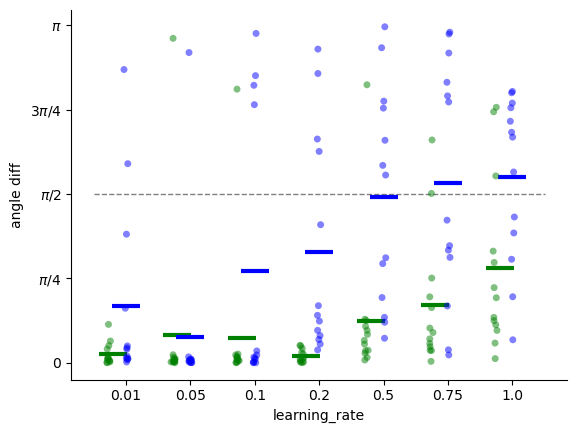

In [7]:
fig, ax = plt.subplots()
colors = ['green', 'blue']
sns.stripplot(data=offset_df, x='learning_rate', 
              y='angle diff', hue='rule', dodge=True, alpha=.5,
              ax=ax, legend=False,palette=colors,)
sns.pointplot(data=offset_df, x = 'learning_rate', y = 'angle diff',
              hue = 'rule', estimator=np.mean,
              linestyle='none', dodge=.4, errorbar=None,
              marker="_", markersize=20, markeredgewidth=3,
              ax=ax, legend=False, palette=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
              labels=['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])

ax.hlines(np.pi/2, -0.5, 6.5, color='black', linestyle='--', linewidth=1,
          alpha=.5, zorder=-1)
fig.savefig(figfolder / 'simulated_learning_rate_vs_angle_diff.pdf')

In [8]:
real_dat_offset_dict = { 'fly_id':[],
                        'rule': [],
                'angle diff': []}


for r, fly in enumerate(ctrl_fly_ids):
    
    fly_df = sess_df.loc[sess_df['fly_id']==fly]
    if np.sort(fly_df['closed_loop'].to_numpy()).tolist() == [0,1,2]: # all sessions exist
        offset_dict={}
        for _, row in fly_df.iterrows():
            ts = nmp.session.GetTS(load_row(row))
            offset_dict[row['closed_loop']]= np.angle(ts.offset_c.mean())
    else:
        pass
    
    offset1 = offset_dict[1]
    offset2 = offset_dict[2]

    real_dat_offset_dict['fly_id'].append(fly)
    real_dat_offset_dict['rule'].append('real')
    real_dat_offset_dict['angle diff'].append(np.abs(np.angle(np.exp(1j*(offset1 - offset2)))))
    
real_dat_offset_df = pd.DataFrame(real_dat_offset_dict)
offset_df = pd.concat([offset_df, real_dat_offset_df], ignore_index=True)




In [22]:
tmp_offset_df

,fly_id,learning_rate,rule,cl1_mu_offset,cl2_mu_offset,angle diff
182,06_01_2025_fly1_control,NaN,real,NaN,NaN,0.208513
183,06_01_2025_fly2_control,NaN,real,NaN,NaN,0.313929
184,07_01_2025_fly1_control,NaN,real,NaN,NaN,0.022059
185,07_01_2025_fly2_control,NaN,real,NaN,NaN,0.257160
186,09_01_2025_fly1_control,NaN,real,NaN,NaN,1.338319
187,09_01_2025_fly3_control,NaN,real,NaN,NaN,0.012289
188,09_01_2025_fly4_control,NaN,real,NaN,NaN,1.829270
189,04_02_2025_fly5_control,NaN,real,NaN,NaN,0.276310
190,04_02_2025_fly6_control,NaN,real,NaN,NaN,0.036495
191,04_02_2025_fly2_control,NaN,real,NaN,NaN,0.036495


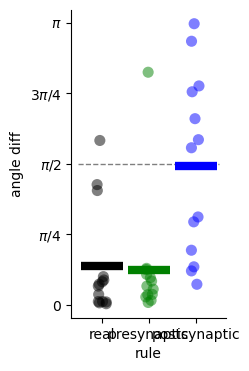

In [60]:
# gridspec with width ratios 1,2
from matplotlib.gridspec import GridSpec as GS

fig, ax = plt.subplots(figsize=[2,4])
# gs = GS(1,2, figure=fig, width_ratios=[1,2],wspace=.05)

# real_ax = fig.add_subplot(gs[0,0])
# sim_ax = fig.add_subplot(gs[0,1], sharey=real_ax)

colors = ['green' ,'blue', 'black']
tmp_offset_df = offset_df.loc[(offset_df['rule']=='real') | (offset_df['learning_rate']==.5)]
sns.stripplot(data=tmp_offset_df, x='rule', 
              y='angle diff', dodge=False, alpha=.5,
              ax=ax, legend=False, palette=colors, hue='rule', 
              order = ['real', 'presynaptic', 'postsynaptic'], s=8)
sns.pointplot(data=tmp_offset_df, x = 'rule', y = 'angle diff',
               estimator=np.mean, linestyle='none', errorbar=None,
               marker="_", markersize=30, markeredgewidth=6,
              ax=ax, hue='rule', palette=colors, order = ['real', 'presynaptic', 'postsynaptic'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi],
              labels=['0', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$'])
ax.hlines(np.pi/2, -0.5, 2.5, color='black', linestyle='--', linewidth=1,
          alpha=.5, zorder=-1)
fig.savefig(figfolder / 'simulated_vs_real_angle_diff.pdf')

In [10]:

weights_dict = { 'fly_id':[],
                'learning_rate': [],
                'rule': [],
                'start_weights': [],
                'end_weights': [],}

for fly in ctrl_fly_ids:

    print(fly)
    for lr in learning_rates:
        with open(simdatadir / f"{fly}_results_learning_rate_{lr}.pkl", 'rb') as f:
            sim_data = pickle.load(f)

        for key in ['presynaptic', 'postsynaptic']:
            _sim_data = sim_data[key]
            if 'cl1' in _sim_data['start_end_times']:

                time = _sim_data['time'][1:]
                dark_times = _sim_data['start_end_times']['dark']
                

                weights = _sim_data['weights'][(time >= dark_times[0]) & (time <= dark_times[1]), :, :]

                weights_dict['fly_id'].append(fly)
                weights_dict['learning_rate'].append(lr)
                weights_dict['rule'].append(key)
                weights_dict['start_weights'].append(weights[0])
                weights_dict['end_weights'].append(weights[-1])

weights_df = pd.DataFrame(weights_dict)




06_01_2025_fly1_control
06_01_2025_fly2_control
07_01_2025_fly1_control
07_01_2025_fly2_control
09_01_2025_fly1_control
09_01_2025_fly3_control
09_01_2025_fly4_control
11_01_2025_fly3_control
17_01_2025_fly2_control
04_02_2025_fly5_control
04_02_2025_fly6_control
04_02_2025_fly2_control
05_02_2025_fly1_control
05_02_2025_fly2_control
05_02_2025_fly3_control
05_02_2025_fly5_control


In [11]:


for i, row in weights_df.iterrows():
    print(row['fly_id'], row['learning_rate'], row['rule'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    h = ax[0].imshow(row['start_weights'], vmin=0, vmax=.33)
    plt.colorbar(h, ax=ax[0])
    ax[0].set_title('Start Weights')
    h = ax[1].imshow(row['end_weights'], vmin=0, vmax=.33)
    plt.colorbar(h, ax=ax[1])
    ax[1].set_title('End Weights')
    fig.suptitle(f"{row['fly_id']} - {row['learning_rate']} - {row['rule']}")

    tmp_figfolder = figfolder / 'simulation_figs' / row['fly_id']
    tmp_figfolder.mkdir(parents=True, exist_ok=True)
    fig.savefig(tmp_figfolder / f"{row['learning_rate']}_{row['rule']}_weights.pdf")
    plt.close(fig)
    

06_01_2025_fly1_control 0.01 presynaptic
06_01_2025_fly1_control 0.01 postsynaptic
06_01_2025_fly1_control 0.05 presynaptic
06_01_2025_fly1_control 0.05 postsynaptic
06_01_2025_fly1_control 0.1 presynaptic
06_01_2025_fly1_control 0.1 postsynaptic
06_01_2025_fly1_control 0.2 presynaptic
06_01_2025_fly1_control 0.2 postsynaptic
06_01_2025_fly1_control 0.5 presynaptic
06_01_2025_fly1_control 0.5 postsynaptic
06_01_2025_fly1_control 0.75 presynaptic
06_01_2025_fly1_control 0.75 postsynaptic
06_01_2025_fly1_control 1.0 presynaptic
06_01_2025_fly1_control 1.0 postsynaptic
06_01_2025_fly2_control 0.01 presynaptic
06_01_2025_fly2_control 0.01 postsynaptic
06_01_2025_fly2_control 0.05 presynaptic
06_01_2025_fly2_control 0.05 postsynaptic
06_01_2025_fly2_control 0.1 presynaptic
06_01_2025_fly2_control 0.1 postsynaptic
06_01_2025_fly2_control 0.2 presynaptic
06_01_2025_fly2_control 0.2 postsynaptic
06_01_2025_fly2_control 0.5 presynaptic
06_01_2025_fly2_control 0.5 postsynaptic
06_01_2025_fly2_co

(32, 233445) (233445,) (233445,) (233445,)
(32, 233445) (233445,) (233445,) (233445,)
(32, 282373) (282373,) (282373,) (282373,)
(32, 282373) (282373,) (282373,) (282373,)
(32, 221488) (221488,) (221488,) (221488,)
(32, 221488) (221488,) (221488,) (221488,)
(32, 240065) (240065,) (240065,) (240065,)
(32, 240065) (240065,) (240065,) (240065,)
(32, 229803) (229803,) (229803,) (229803,)
(32, 229803) (229803,) (229803,) (229803,)
(32, 227428) (227428,) (227428,) (227428,)
(32, 227428) (227428,) (227428,) (227428,)
(32, 241039) (241039,) (241039,) (241039,)
(32, 241039) (241039,) (241039,) (241039,)
(32, 181036) (181036,) (181036,) (181036,)
(32, 181036) (181036,) (181036,) (181036,)
(32, 191048) (191048,) (191048,) (191048,)
(32, 191048) (191048,) (191048,) (191048,)
(32, 214957) (214957,) (214957,) (214957,)
(32, 214957) (214957,) (214957,) (214957,)
(32, 204149) (204149,) (204149,) (204149,)
(32, 204149) (204149,) (204149,) (204149,)


/tmp/ipykernel_1473537/2310847914.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=[8,6])


(32, 192830) (192830,) (192830,) (192830,)
(32, 192830) (192830,) (192830,) (192830,)
(32, 202630) (202630,) (202630,) (202630,)
(32, 202630) (202630,) (202630,) (202630,)


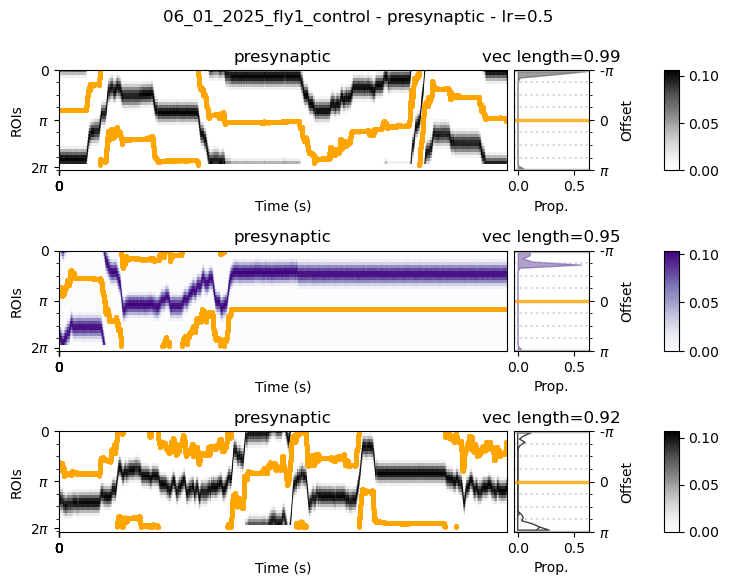

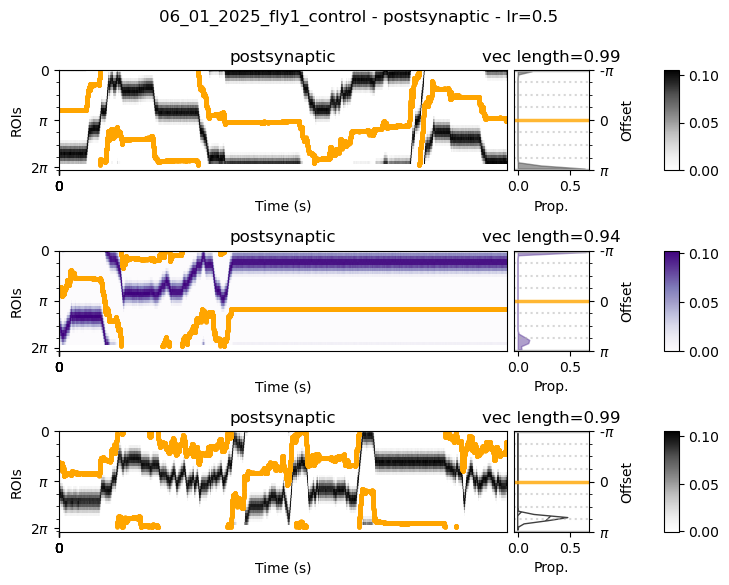

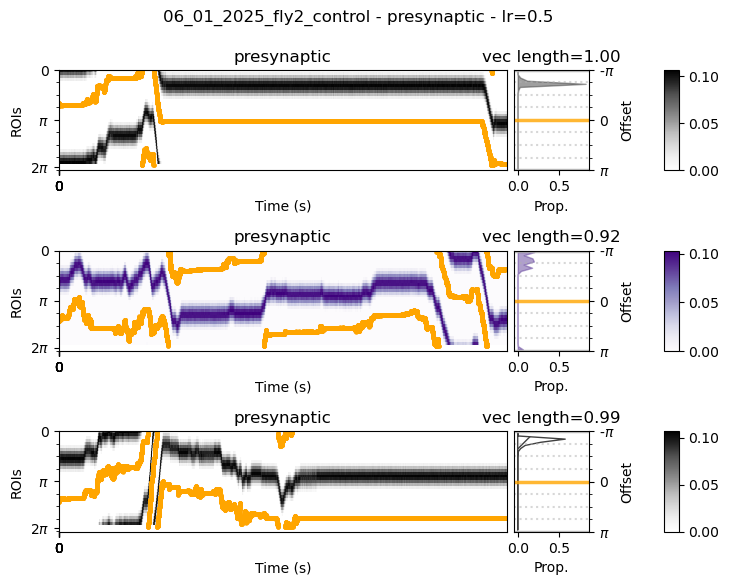

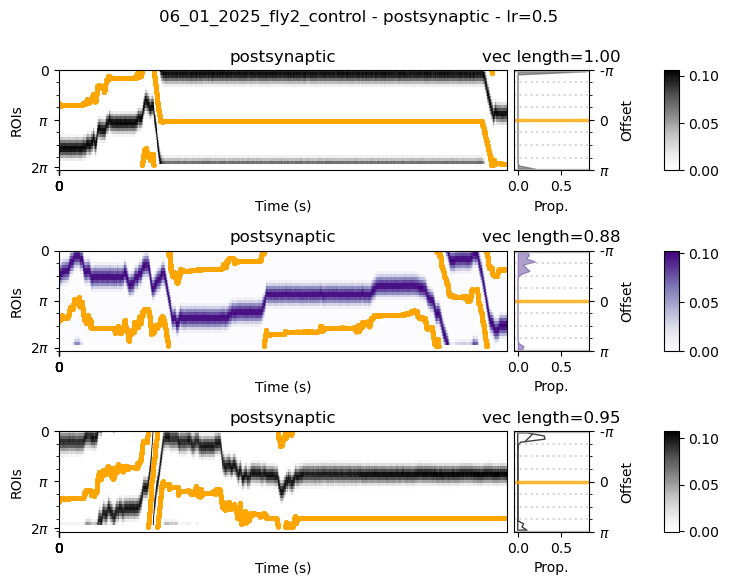

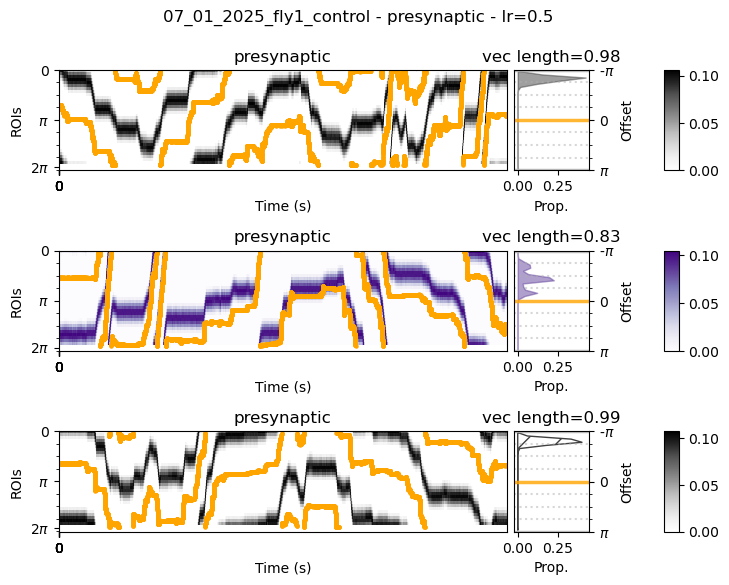

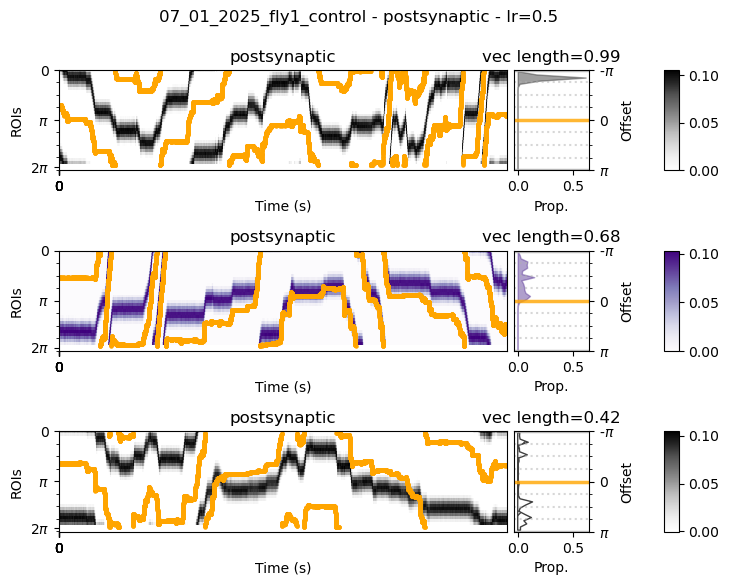

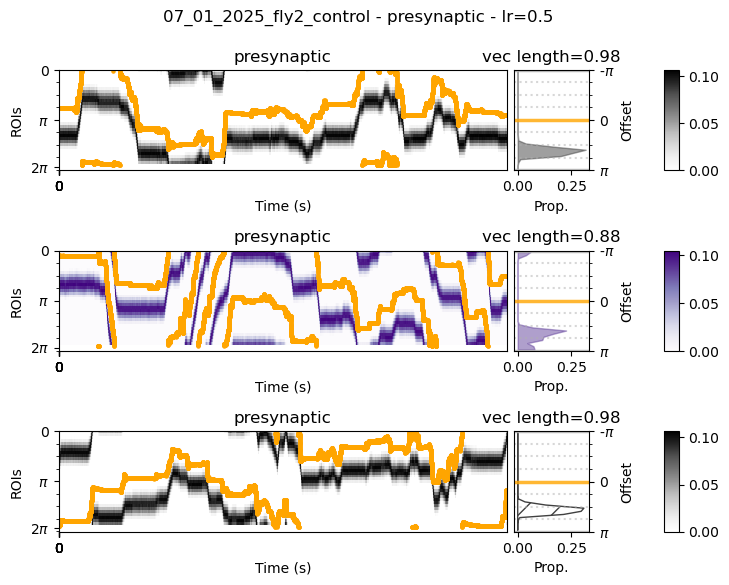

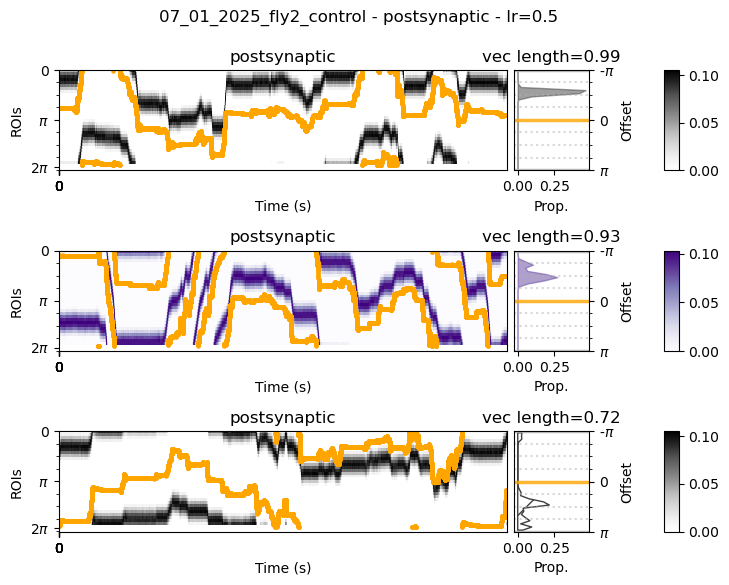

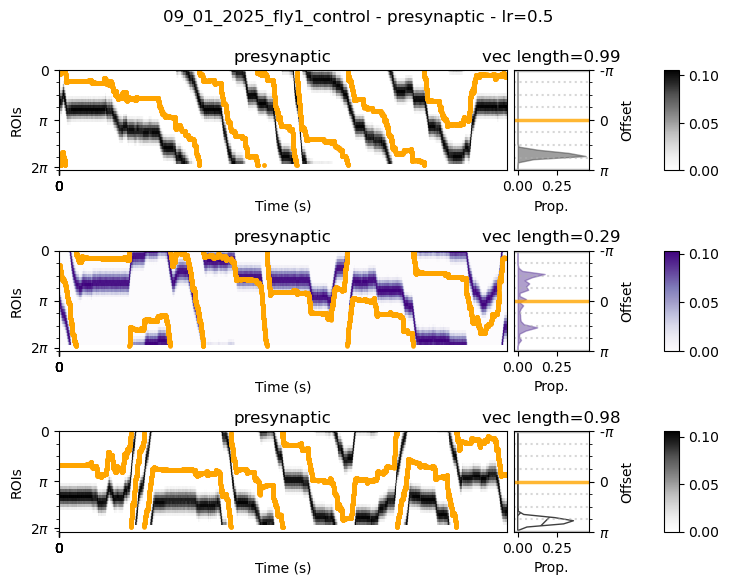

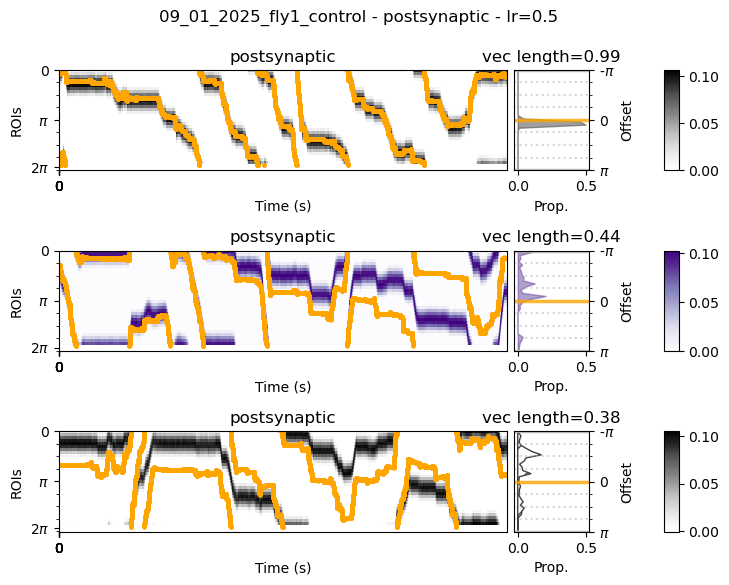

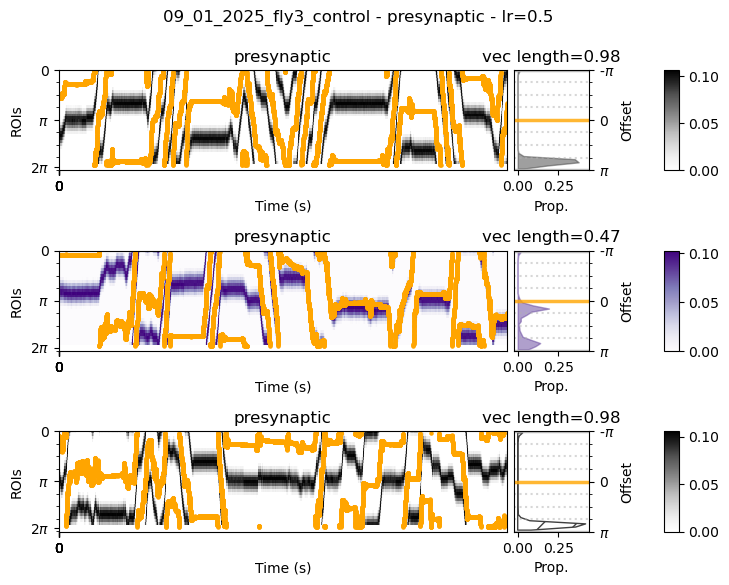

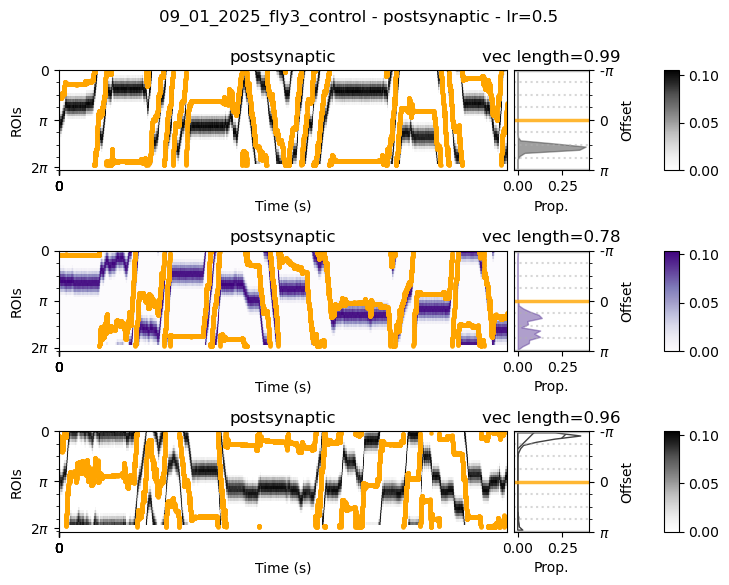

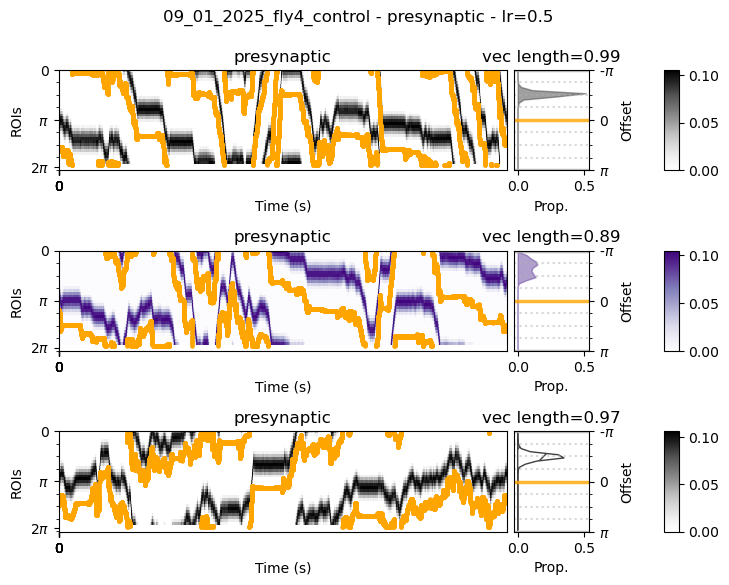

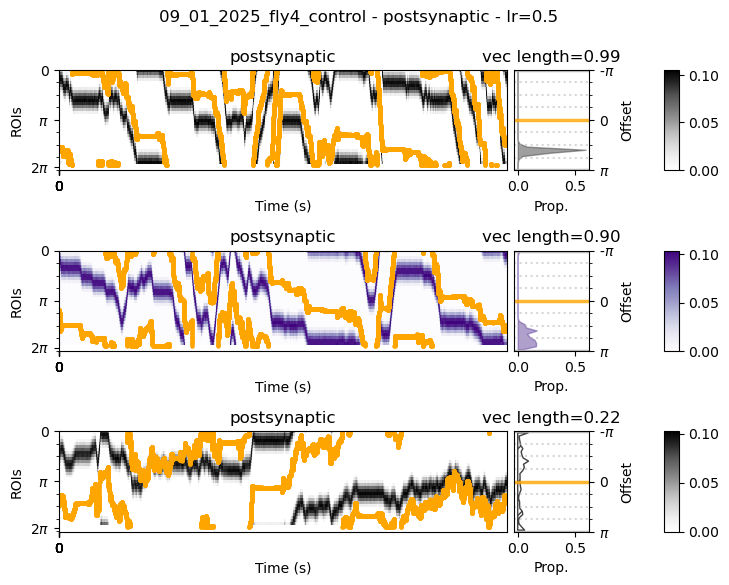

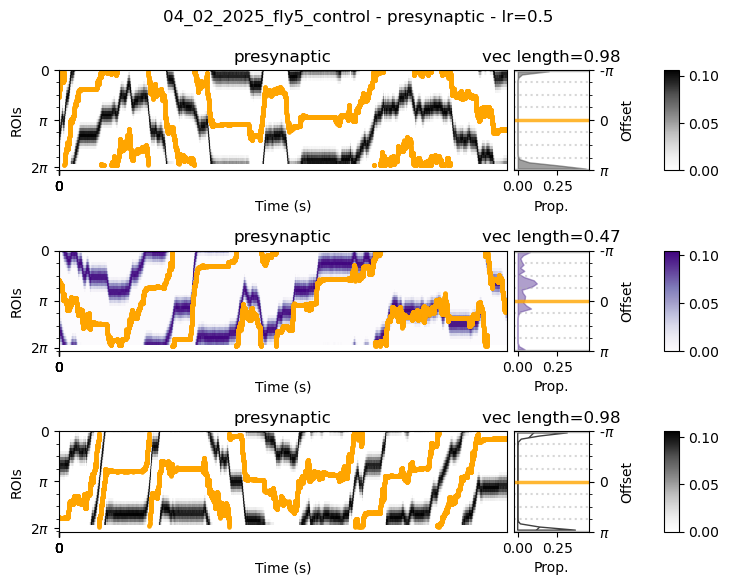

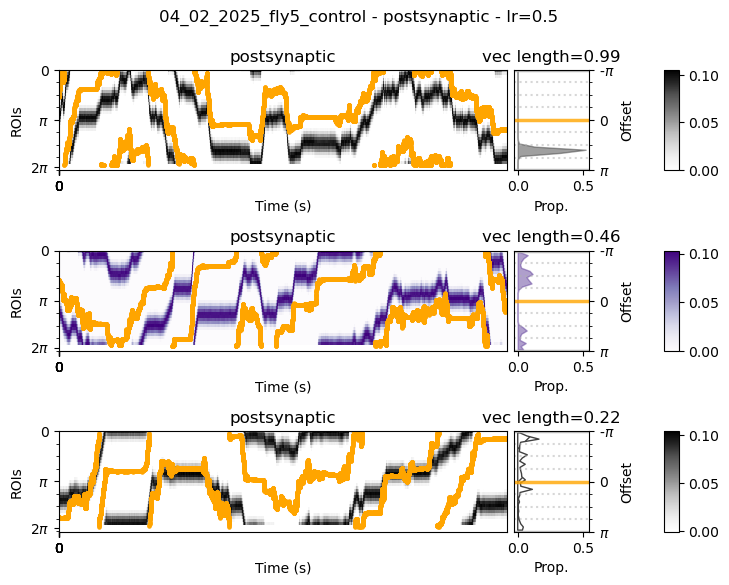

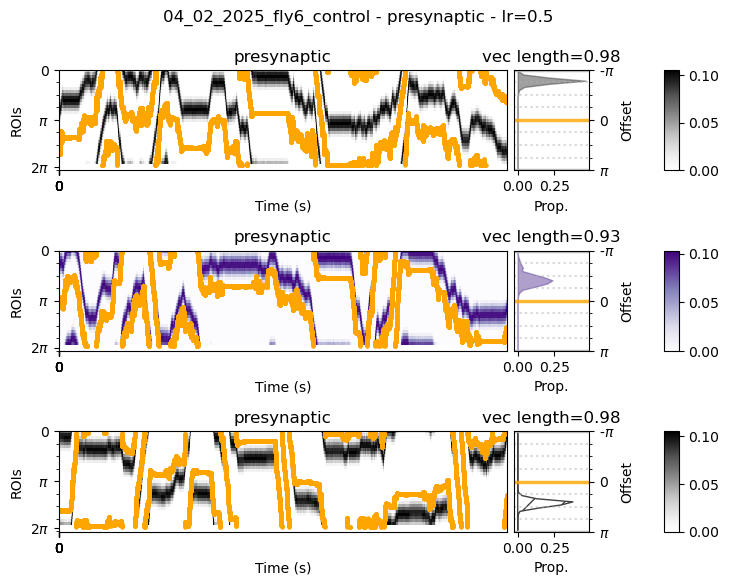

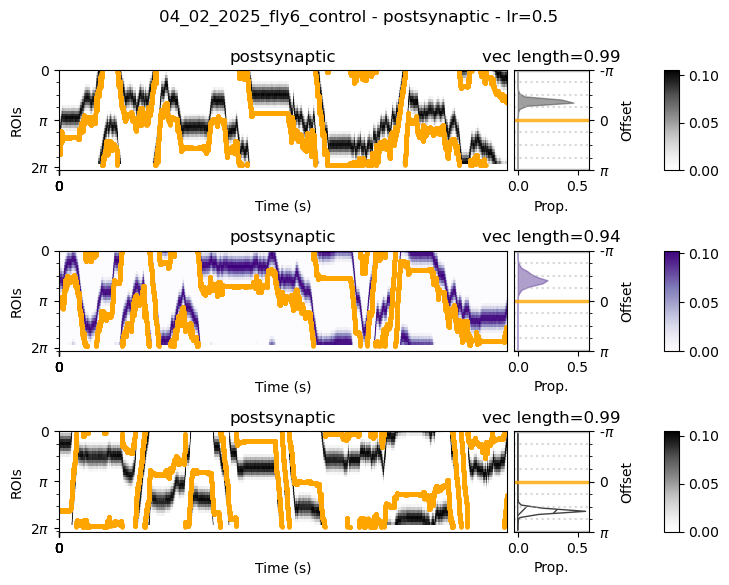

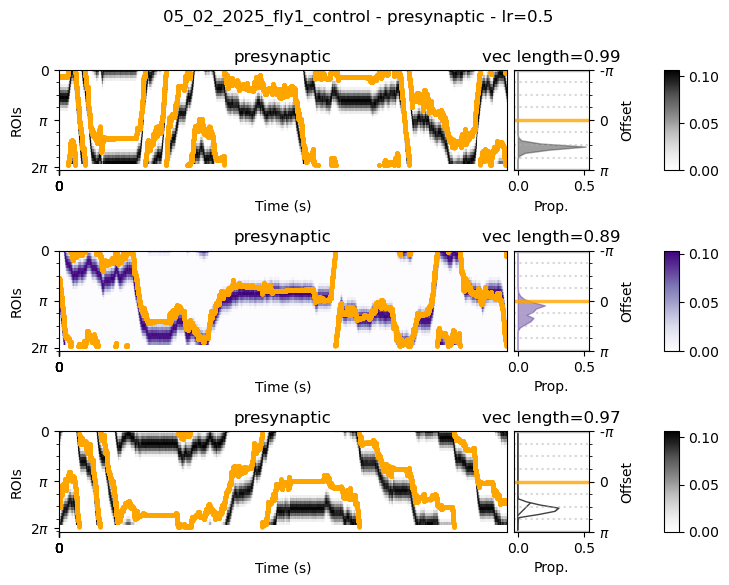

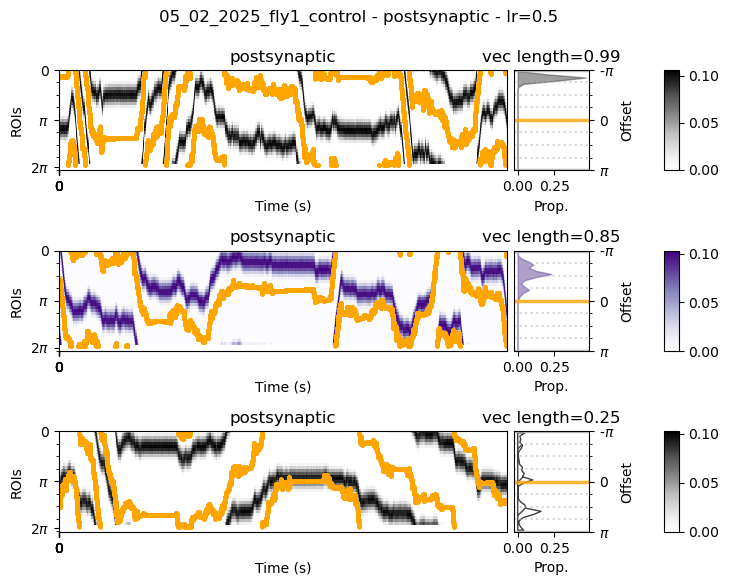

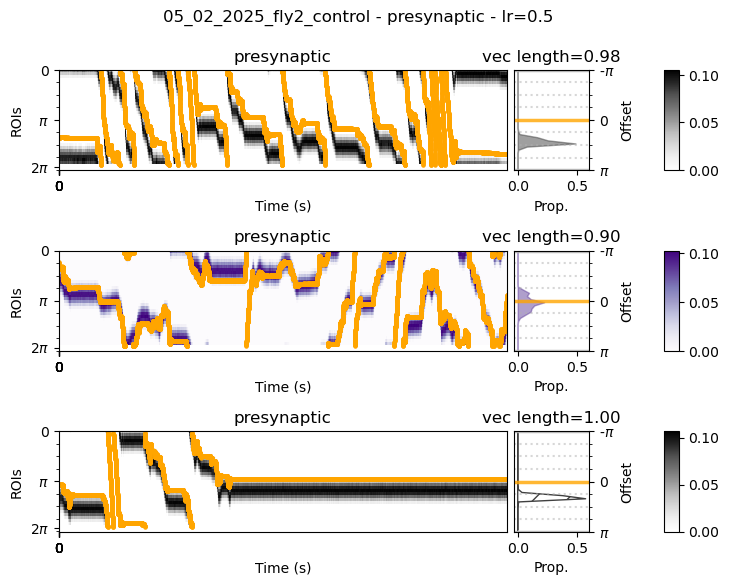

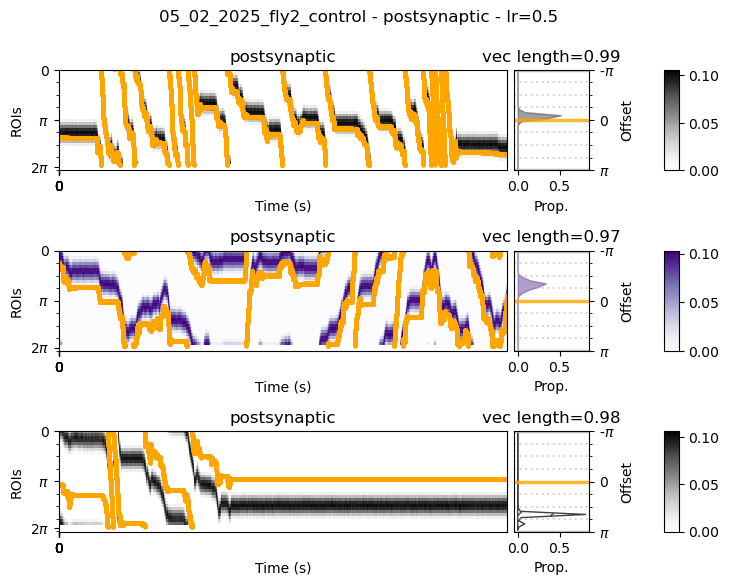

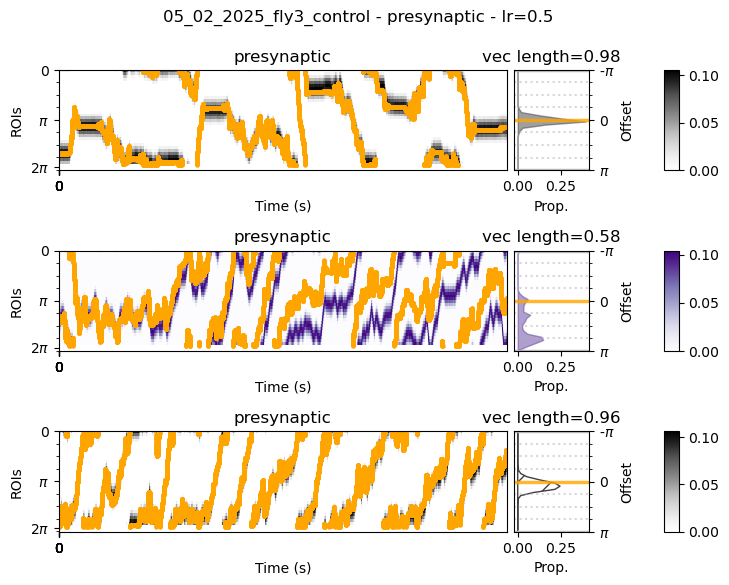

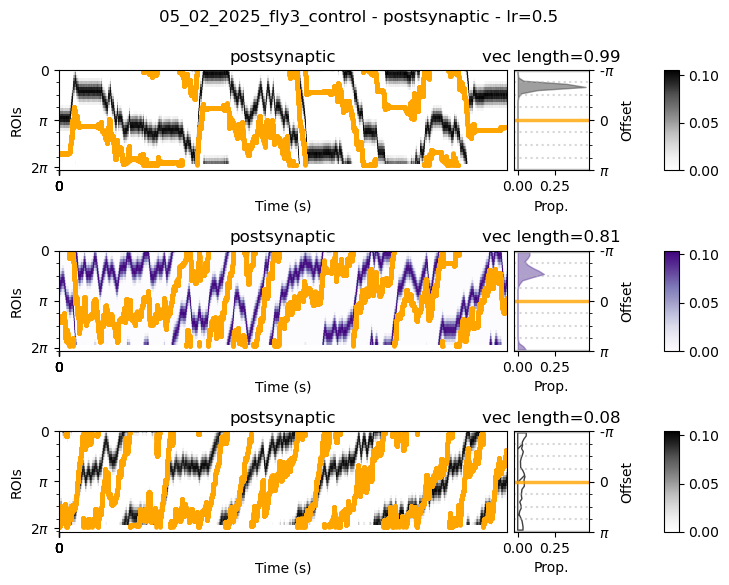

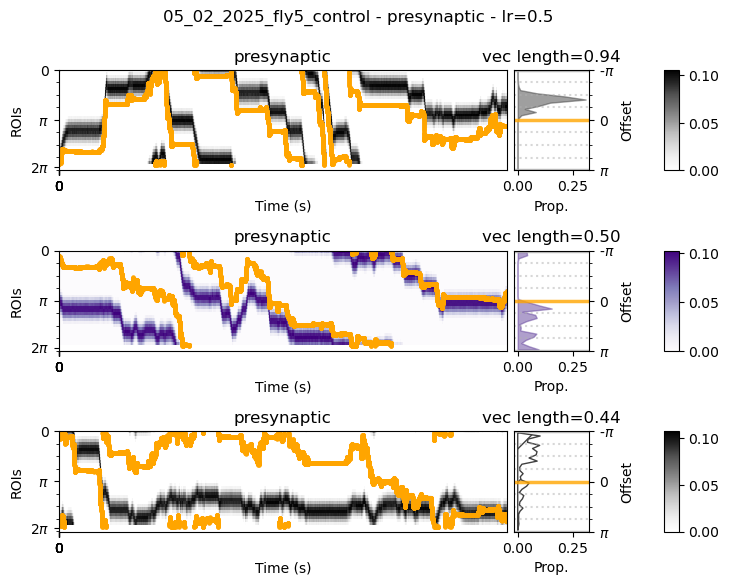

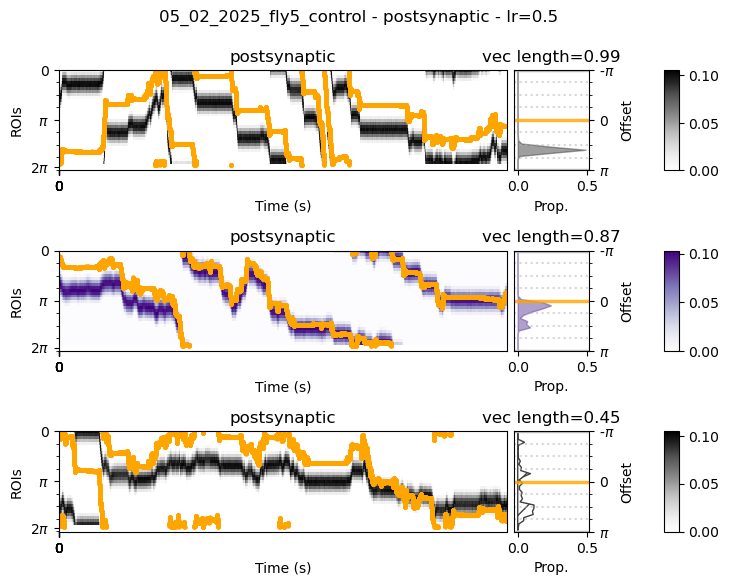

In [ ]:
# plot an example from moderate learning rate
def get_time_ticks_inds(time, plot_times=np.arange(0,360,60)):
        inds = []
        for t in plot_times:
            inds.append(np.argmin(np.abs(time-t)))
        return inds


lr = .5

for fly in ctrl_fly_ids:
    with open(simdatadir / f"{fly}_results_learning_rate_{lr}.pkl", 'rb') as f:
        sim_data = pickle.load(f)

    for key in ['presynaptic', 'postsynaptic']:
        _sim_data = sim_data[key]

        
        if 'cl1' in _sim_data['start_end_times']:
                cl1_times = _sim_data['start_end_times']['cl1']
                cl2_times = _sim_data['start_end_times']['cl2']
                dark_times = _sim_data['start_end_times']['dark']

                heading = _sim_data['heading'][1:]
                heading_ = (heading+np.pi)/2/np.pi*32
                time = _sim_data['time'][1:]
                offset = _sim_data['offset']
                dff = _sim_data['dff']
                print(dff.shape, time.shape, heading_.shape, offset.shape)

                fig = plt.figure(figsize=[8,6])
                gs = GS(3,4, figure=fig, width_ratios=[6,1,.8, .2],wspace=.05,hspace=.8)
                heatmap_axs = [fig.add_subplot(gs[0,0])]
                heatmap_axs.extend([fig.add_subplot(gs[i,0],sharey=heatmap_axs[0]) for i in range(1,3)])
                hist_axs = [fig.add_subplot(gs[0,1])]
                hist_axs.extend([fig.add_subplot(gs[i,1],sharex=hist_axs[0]) for i in range(1,3)])
                cbar_ax = [fig.add_subplot(gs[i,3]) for i in range(3)]

                def plot_row(_dff, _heading, _offset, _time, row, cmap, hatch=None):
                        
                    x = np.arange(_dff.shape[1])
                    _dff = _dff[::-1, :]  # flip so that ROI 0 is at bottom
                    heading_ = 32 - (_heading + np.pi) / (2 * np.pi) * 32

                    h = heatmap_axs[row].imshow(_dff, aspect='auto', cmap=cmap, interpolation='none')
                    fig.colorbar(h, cax=cbar_ax[row])
                    heatmap_axs[row].scatter(x, heading_, color='orange', s=5)

                    heatmap_axs[row].set_ylabel('ROIs')
                    heatmap_axs[row].set_yticks([-0.5,16.5,32.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
                    heatmap_axs[row].yaxis.set_minor_locator(AutoMinorLocator())
                    
                    # _plot_times = plot_times[plot_times<_time[-1]]
                    heatmap_axs[row].set_xticks(get_time_ticks_inds(_time))
                    heatmap_axs[row].set_xlabel('Time (s)')
                    
                    heatmap_axs[row].set_title(key)

                    
                    bins = np.linspace(-np.pi, np.pi, num=33)
                    centers = (bins[:-1] + bins[1:]) / 2
                    hist, _ = np.histogram(_offset, bins=bins)
                    hist = hist / hist.sum()  # normalize
                    if hatch is None:
                        hist_axs[row].fill_betweenx(centers, 0, hist, color=cmap(.8), alpha=.5)
                    else:
                        hist_axs[row].fill_betweenx(centers, 0, hist, alpha=1, hatch=hatch,color='none', edgecolor=cmap(.8))

                    # hist_axs[row].set_yticks([-np.pi,-3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
                    #                          labels=[r'-$\pi$', '', '', '', r'0','', '', '', r'$\pi$'])
                    hist_axs[row].set_yticks([-np.pi, 0,  np.pi], 
                                            labels=[r'-$\pi$',  r'0', r'$\pi$'])
                    hist_axs[row].yaxis.set_minor_locator(AutoMinorLocator())
                    hist_axs[row].set_ylim([np.pi, -np.pi])
                    # hist_axs[row].set_xlim(left=0)
                    hist_axs[row].grid(True, axis='y', linestyle='-', alpha=0.8,linewidth=2.5, which='major')
                    ygridlines = hist_axs[row].get_ygridlines()
                    ygridlines[1].set_color('orange')
                    hist_axs[row].grid(True, axis='y', linestyle=':', alpha=0.5, linewidth=1.5, which='minor')
                    hist_axs[row].set_ylabel('Offset')
                    hist_axs[row].yaxis.tick_right()
                    hist_axs[row].yaxis.set_label_position('right')
                    hist_axs[row].set_xlabel('Prop.')

                    offset_len = np.abs(np.exp(1j*_offset).mean())
                    # offset_var = sp.stats.circvar(offset, low=-np.pi, high=np.pi)
                    # hist_axs[row].set_title(f"variance={offset_var:.2f}" )
                    hist_axs[row].set_title(f"vec length={offset_len:.2f}" )

            




                cl1_mask = (time >= cl1_times[0]) & (time <= cl1_times[0]+180)
                cl2_mask = (time >= cl2_times[0]) & (time <= cl2_times[0]+180)
                dark_mask = (time >= dark_times[0]) & (time <= dark_times[0]+180)


                plot_row(dff[:, cl1_mask], heading[cl1_mask], offset[cl1_mask], time[cl1_mask], 0, plt.cm.Greys)
                plot_row(dff[:, dark_mask], heading[dark_mask], offset[dark_mask], time[dark_mask], 1, plt.cm.Purples, hatch=None)
                plot_row(dff[:, cl2_mask], heading[cl2_mask], offset[cl2_mask], time[cl2_mask], 2, plt.cm.Greys, hatch='/')
                # x = time[cl1_mask]
                # x = np.arange(x.shape[0]) #x - x[0]
                # ax[0].imshow(dff[:,cl1_mask], aspect='auto', cmap='Greys')
                # ax[0].scatter(x, heading_[cl1_mask], c='orange', s=1, alpha=.5)
                # x= time[dark_mask]
                # x = np.arange(x.shape[0])
                # ax[1].imshow(dff[:, dark_mask], aspect='auto', cmap='Purples')
                # ax[1].scatter(x, heading_[dark_mask], c='orange', s=1, alpha=.5)
                # ax[2].imshow(dff[:, cl2_mask], aspect='auto', cmap='Greys')
                # x = time[cl2_mask]
                # x = np.arange(x.shape[0])
                # ax[2].scatter(x, heading_[cl2_mask], c='orange', s=1, alpha=.5)

                # # set time for each sessin
                # _t = time[cl2_mask]
                # ax[2].set_xticks(get_time_ticks_inds(_t -_t[0]))

                fig.suptitle(f"{fly} - {key} - lr={lr}")

                # make histograme of offset and plot


                # set title

                # save

In [44]:
time[cl1_mask]

array([1083.07, 1083.08, 1083.09, ..., 1570.92, 1570.93, 1570.94])